In [1]:
import sys
# append the path of the parent directory
sys.path.append("..")

# External library imports
import datetime
import torch
import torch.nn as nn
import numpy as np
import random
import gc
from torch.optim import Adam
from torch.utils.data import DataLoader, Subset, random_split
import matplotlib.pyplot as plt


# internal library imports
from dataset import DebrisStatePairsDataset
from model import CNN, UNet
from train import TrainerPairs, CustomDebrisLoss, SparseLoss, AdaptiveSparseLoss
from util.setting_utils import set_seed

import optuna
from optuna.exceptions import TrialPruned
import optuna.visualization as vis

In [2]:
# Parameters

root_dir = r'/home/tom/repos/dyna-landslide-surrogate/data_experiment_prune'
checkpoint_dir = r'/home/tom/repos/dyna-landslide-surrogate/checkpoints'
batch_size = 32
split_proportions = (0.7, 0.15, 0.15)
epochs = 15

timestep_interval = 5
experiment = "base_model_compar_adaploss_batch32_timestep5_lr1e-4_l2reg_drop0-2_expdata_prune_MedUNet"

in_channels = 3  # Number of input channels (e.g., terrain, velocity, thickness)
out_channels = 2  # Number of output channels (e.g., next velocity, next thickness)

In [3]:
# Set up CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}.")


Training on device: cuda.


In [4]:

def objective(trial):

    study_name = 'attempt3'

    # Define hyperparameters to tune
    features_str = trial.suggest_categorical('features', ('64,128,256', '64,128,256,512'))
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-4, log=True)
    timestep_interval = trial.suggest_int('timestep_interval', 1, 10)
    batch_size = trial.suggest_categorical('batch_size', (4, 8, 16, 32))

    features = list(map(int, features_str.split(',')))
    dataset = DebrisStatePairsDataset(root_dir, array_size=256, apply_scaling=True, timestep_interval=timestep_interval)
    train_loader, val_loader, test_loader = dataset.create_dataloaders(split_proportions, batch_size, random_state=42)

    try:
        # Model creation and setup for multi-GPU
        model = UNet(in_channels=in_channels, out_channels=out_channels, features=features, dropout_rate=dropout_rate)
        # if torch.cuda.device_count() > 1:
        #     model = torch.nn.DataParallel(model)
        model.to(device)

        # Loss and optimizer
        criterion = AdaptiveSparseLoss()
        optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

        # Trainer initialization and training execution
        trainer = TrainerPairs(model, optimizer, criterion, device, f"{study_name}_trial_{trial.number}", checkpoint_dir, 10)
        trainer.train(train_loader, val_loader, epochs=epochs)
        best_val_loss = min(trainer.validation_losses)

    except RuntimeError as e:
        if 'CUDA out of memory' in str(e):
            # CUDA memory issue encountered, prune the trial
            print(f"Trial {trial.number} pruned due to CUDA out of memory error.")
            raise TrialPruned()
        else:
            # Other runtime error, re-raise the exception
            raise

    finally:
        # Cleanup to prevent memory leaks
        del model, optimizer, trainer
        torch.cuda.empty_cache()
        gc.collect()

    return best_val_loss

[I 2024-04-27 22:46:49,393] A new study created in memory with name: attempt3


Epoch [1/15], Loss: 0.0806
Validation Loss: 0.0839
Current Learning Rate: [5.685451038166201e-05]
Epoch [2/15], Loss: 0.0422
Validation Loss: 0.0318
Current Learning Rate: [5.685451038166201e-05]
Epoch [3/15], Loss: 0.0245
Validation Loss: 0.0302
Current Learning Rate: [5.685451038166201e-05]
Epoch [4/15], Loss: 0.0224
Validation Loss: 0.0278
Current Learning Rate: [5.685451038166201e-05]
Epoch [5/15], Loss: 0.0214
Validation Loss: 0.0288
Current Learning Rate: [5.685451038166201e-05]
Model saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/attempt3_trial_0/model_epoch_5.pth
Epoch [6/15], Loss: 0.0205
Validation Loss: 0.0285
Current Learning Rate: [5.685451038166201e-05]
Epoch [7/15], Loss: 0.0199
Validation Loss: 0.0257
Current Learning Rate: [5.685451038166201e-05]
Epoch [8/15], Loss: 0.0194
Validation Loss: 0.0261
Current Learning Rate: [5.685451038166201e-05]
Epoch [9/15], Loss: 0.0188
Validation Loss: 0.0248
Current Learning Rate: [5.685451038166201e-05]
Epoch [10/15], 

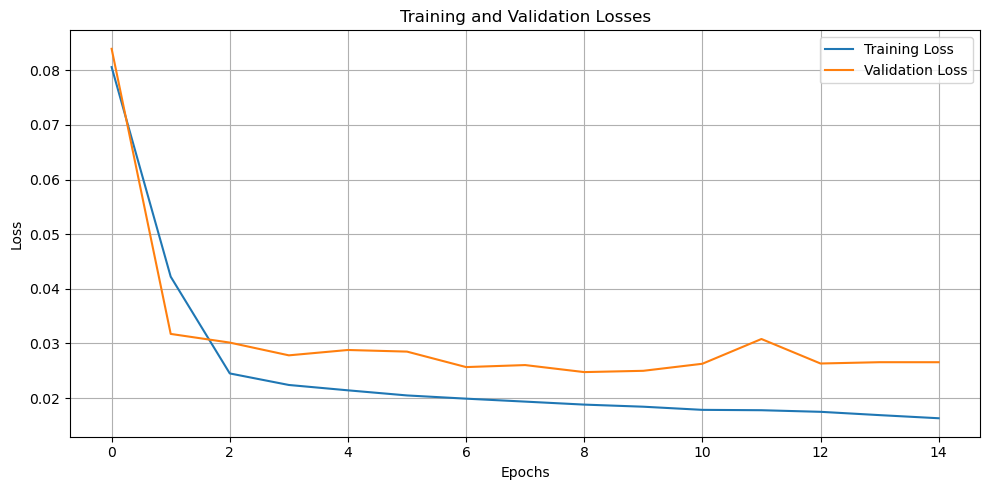

[I 2024-04-27 23:11:20,113] Trial 0 finished with value: 0.024764311674516648 and parameters: {'features': '64,128,256,512', 'dropout_rate': 0.4571396197026608, 'learning_rate': 5.685451038166201e-05, 'weight_decay': 4.953055711266055e-06, 'timestep_interval': 5, 'batch_size': 16}. Best is trial 0 with value: 0.024764311674516648.


Epoch [1/15], Loss: 0.1056
Validation Loss: 0.1043
Current Learning Rate: [2.23353132765603e-05]
Epoch [2/15], Loss: 0.0808
Validation Loss: 0.0991
Current Learning Rate: [2.23353132765603e-05]
Epoch [3/15], Loss: 0.0696
Validation Loss: 0.0533
Current Learning Rate: [2.23353132765603e-05]
Epoch [4/15], Loss: 0.0324
Validation Loss: 0.0372
Current Learning Rate: [2.23353132765603e-05]
Epoch [5/15], Loss: 0.0268
Validation Loss: 0.0345
Current Learning Rate: [2.23353132765603e-05]
Model saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/attempt3_trial_1/model_epoch_5.pth
Epoch [6/15], Loss: 0.0250
Validation Loss: 0.0331
Current Learning Rate: [2.23353132765603e-05]
Epoch [7/15], Loss: 0.0237
Validation Loss: 0.0311
Current Learning Rate: [2.23353132765603e-05]
Epoch [8/15], Loss: 0.0228
Validation Loss: 0.0302
Current Learning Rate: [2.23353132765603e-05]
Epoch [9/15], Loss: 0.0218
Validation Loss: 0.0304
Current Learning Rate: [2.23353132765603e-05]
Epoch [10/15], Loss: 0.0

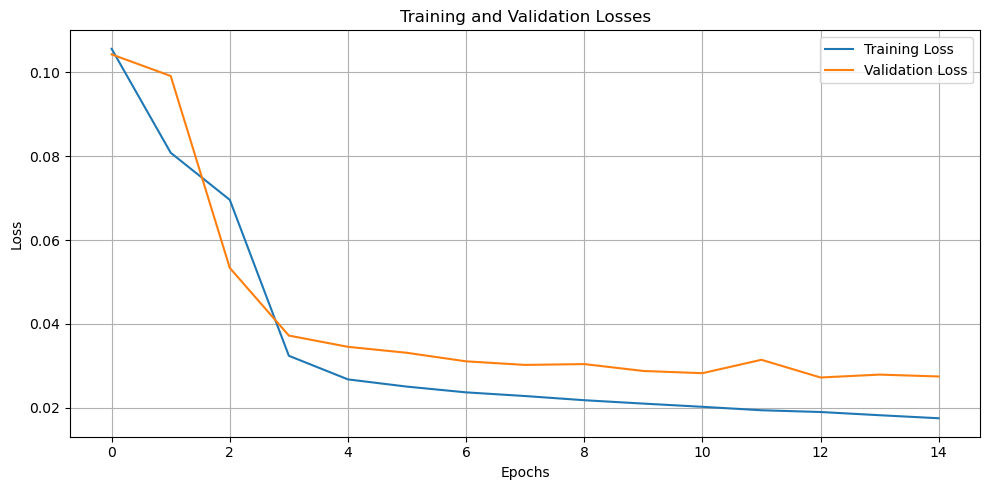

[I 2024-04-27 23:34:01,573] Trial 1 finished with value: 0.02720611763821132 and parameters: {'features': '64,128,256', 'dropout_rate': 0.3164413119059244, 'learning_rate': 2.23353132765603e-05, 'weight_decay': 1.0607164964713838e-06, 'timestep_interval': 2, 'batch_size': 8}. Best is trial 0 with value: 0.024764311674516648.
[I 2024-04-27 23:34:04,944] Trial 2 pruned. 


Trial 2 pruned due to CUDA out of memory error.


[I 2024-04-27 23:34:08,341] Trial 3 pruned. 


Trial 3 pruned due to CUDA out of memory error.
Epoch [1/15], Loss: 0.0864
Validation Loss: 0.1076
Current Learning Rate: [0.0005011911308715766]
Epoch [2/15], Loss: 0.0843
Validation Loss: 0.1076
Current Learning Rate: [0.0005011911308715766]
Epoch [3/15], Loss: 0.0847
Validation Loss: 0.1076
Current Learning Rate: [0.0005011911308715766]
Epoch [4/15], Loss: 0.0849
Validation Loss: 0.1076
Current Learning Rate: [0.0005011911308715766]
Epoch [5/15], Loss: 0.0848
Validation Loss: 0.1076
Current Learning Rate: [0.0005011911308715766]
Model saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/attempt3_trial_4/model_epoch_5.pth
Epoch [6/15], Loss: 0.0847
Validation Loss: 0.1076
Current Learning Rate: [0.0005011911308715766]
Epoch [7/15], Loss: 0.0841
Validation Loss: 0.1076
Current Learning Rate: [5.0119113087157666e-05]
Epoch [8/15], Loss: 0.0845
Validation Loss: 0.1076
Current Learning Rate: [5.0119113087157666e-05]
Epoch [9/15], Loss: 0.0845
Validation Loss: 0.1076
Current Lear

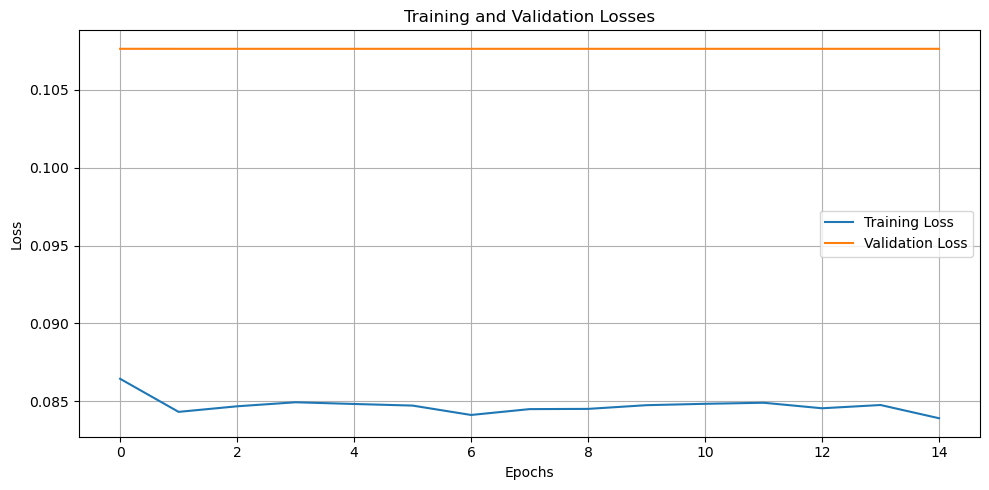

[I 2024-04-28 00:04:05,416] Trial 4 finished with value: 0.10763046193680317 and parameters: {'features': '64,128,256,512', 'dropout_rate': 0.3966760858186654, 'learning_rate': 0.0005011911308715766, 'weight_decay': 6.863245645867055e-06, 'timestep_interval': 1, 'batch_size': 4}. Best is trial 0 with value: 0.024764311674516648.
[I 2024-04-28 00:04:08,547] Trial 5 pruned. 


Trial 5 pruned due to CUDA out of memory error.


[I 2024-04-28 00:04:11,601] Trial 6 pruned. 


Trial 6 pruned due to CUDA out of memory error.


[I 2024-04-28 00:04:15,096] Trial 7 pruned. 


Trial 7 pruned due to CUDA out of memory error.


[I 2024-04-28 00:04:18,129] Trial 8 pruned. 


Trial 8 pruned due to CUDA out of memory error.
Epoch [1/15], Loss: 0.0925
Validation Loss: 0.1071
Current Learning Rate: [0.0006046907125847217]
Epoch [2/15], Loss: 0.0246
Validation Loss: 0.0242
Current Learning Rate: [0.0006046907125847217]
Epoch [3/15], Loss: 0.0186
Validation Loss: 0.0239
Current Learning Rate: [0.0006046907125847217]
Epoch [4/15], Loss: 0.0178
Validation Loss: 0.0241
Current Learning Rate: [0.0006046907125847217]
Epoch [5/15], Loss: 0.0172
Validation Loss: 0.0229
Current Learning Rate: [0.0006046907125847217]
Model saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/attempt3_trial_9/model_epoch_5.pth
Epoch [6/15], Loss: 0.0169
Validation Loss: 0.0225
Current Learning Rate: [0.0006046907125847217]
Epoch [7/15], Loss: 0.0170
Validation Loss: 0.0238
Current Learning Rate: [0.0006046907125847217]
Epoch [8/15], Loss: 0.0167
Validation Loss: 0.0235
Current Learning Rate: [0.0006046907125847217]
Epoch [9/15], Loss: 0.0168
Validation Loss: 0.0230
Current Learni

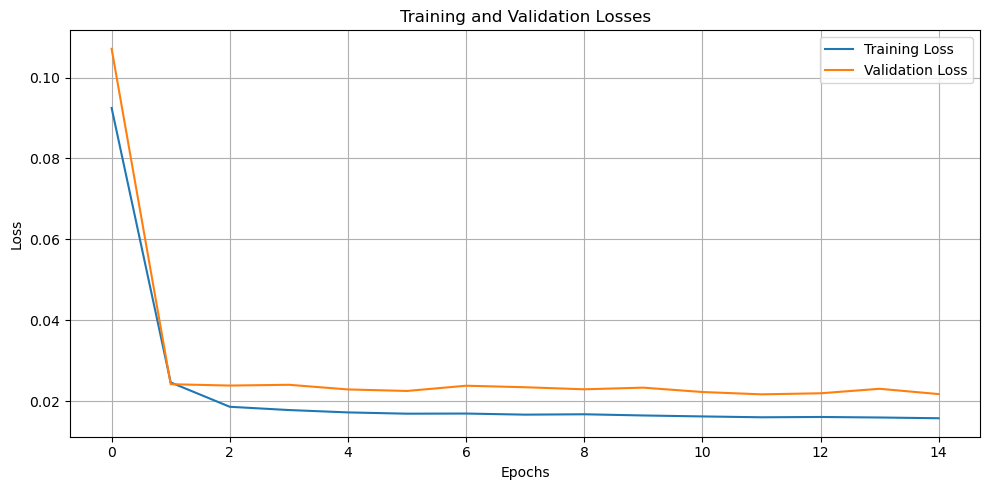

[I 2024-04-28 00:32:18,418] Trial 9 finished with value: 0.02170587465227347 and parameters: {'features': '64,128,256,512', 'dropout_rate': 0.38697766464095684, 'learning_rate': 0.0006046907125847217, 'weight_decay': 2.51544373906166e-06, 'timestep_interval': 1, 'batch_size': 4}. Best is trial 9 with value: 0.02170587465227347.


Epoch [1/15], Loss: 0.0496
Validation Loss: 0.0343
Current Learning Rate: [0.0002499843223893031]
Epoch [2/15], Loss: 0.0245
Validation Loss: 0.0273
Current Learning Rate: [0.0002499843223893031]
Epoch [3/15], Loss: 0.0230
Validation Loss: 0.0290
Current Learning Rate: [0.0002499843223893031]
Epoch [4/15], Loss: 0.0221
Validation Loss: 0.0267
Current Learning Rate: [0.0002499843223893031]
Epoch [5/15], Loss: 0.0217
Validation Loss: 0.0267
Current Learning Rate: [0.0002499843223893031]
Model saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/attempt3_trial_10/model_epoch_5.pth
Epoch [6/15], Loss: 0.0212
Validation Loss: 0.0265
Current Learning Rate: [0.0002499843223893031]
Epoch [7/15], Loss: 0.0210
Validation Loss: 0.0257
Current Learning Rate: [0.0002499843223893031]
Epoch [8/15], Loss: 0.0205
Validation Loss: 0.0268
Current Learning Rate: [0.0002499843223893031]
Epoch [9/15], Loss: 0.0204
Validation Loss: 0.0255
Current Learning Rate: [0.0002499843223893031]
Epoch [10/15],

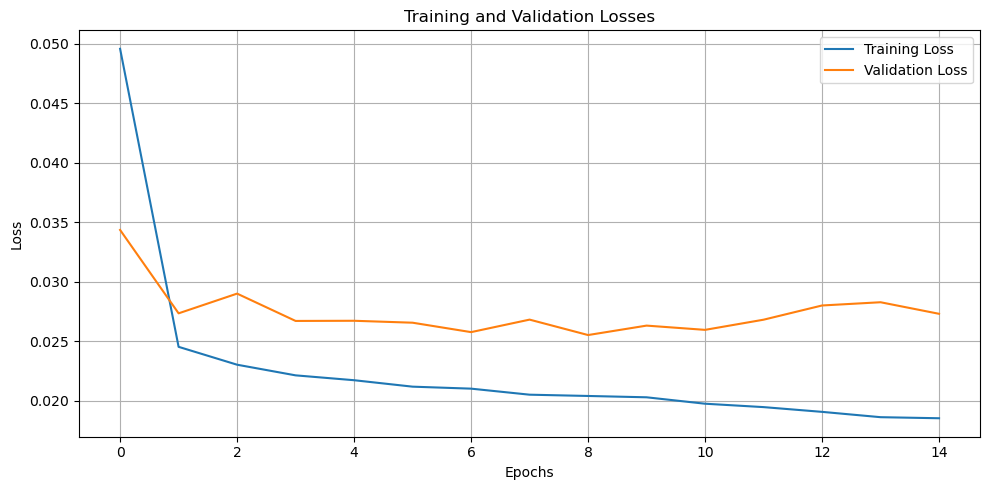

[I 2024-04-28 00:50:49,592] Trial 10 finished with value: 0.02550374505960423 and parameters: {'features': '64,128,256', 'dropout_rate': 0.4969967622216694, 'learning_rate': 0.0002499843223893031, 'weight_decay': 2.570617361534704e-06, 'timestep_interval': 10, 'batch_size': 4}. Best is trial 9 with value: 0.02170587465227347.


Epoch [1/15], Loss: 0.2520
Validation Loss: 0.0963
Current Learning Rate: [3.271181712283856e-05]
Epoch [2/15], Loss: 0.0731
Validation Loss: 0.0819
Current Learning Rate: [3.271181712283856e-05]
Epoch [3/15], Loss: 0.0680
Validation Loss: 0.0728
Current Learning Rate: [3.271181712283856e-05]
Epoch [4/15], Loss: 0.0403
Validation Loss: 0.0387
Current Learning Rate: [3.271181712283856e-05]
Epoch [5/15], Loss: 0.0288
Validation Loss: 0.0341
Current Learning Rate: [3.271181712283856e-05]
Model saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/attempt3_trial_11/model_epoch_5.pth
Epoch [6/15], Loss: 0.0263
Validation Loss: 0.0314
Current Learning Rate: [3.271181712283856e-05]
Epoch [7/15], Loss: 0.0246
Validation Loss: 0.0299
Current Learning Rate: [3.271181712283856e-05]
Epoch [8/15], Loss: 0.0234
Validation Loss: 0.0285
Current Learning Rate: [3.271181712283856e-05]
Epoch [9/15], Loss: 0.0226
Validation Loss: 0.0286
Current Learning Rate: [3.271181712283856e-05]
Epoch [10/15],

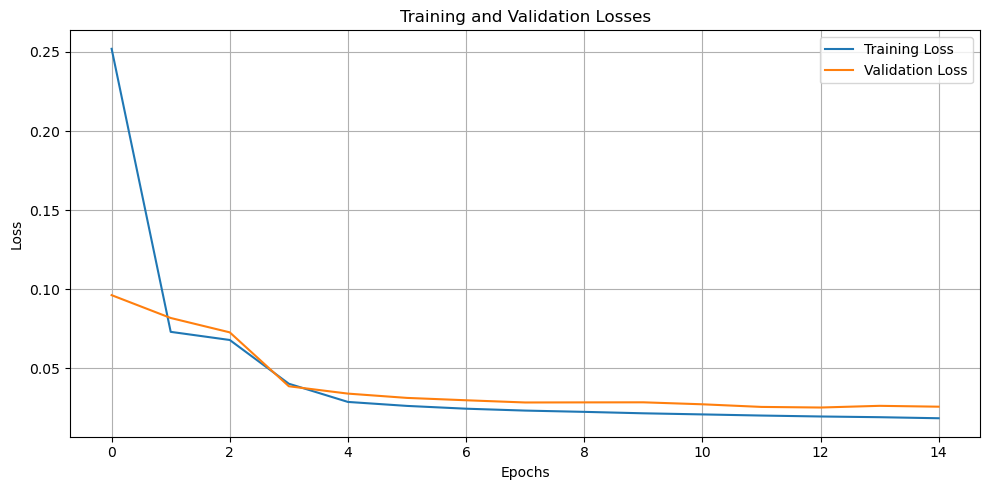

[I 2024-04-28 01:17:14,215] Trial 11 finished with value: 0.025304887489991563 and parameters: {'features': '64,128,256,512', 'dropout_rate': 0.4934177946002717, 'learning_rate': 3.271181712283856e-05, 'weight_decay': 2.9982750288249574e-06, 'timestep_interval': 4, 'batch_size': 4}. Best is trial 9 with value: 0.02170587465227347.


Epoch [1/15], Loss: 0.0721
Validation Loss: 0.0738
Current Learning Rate: [0.00020982595307825853]
Epoch [2/15], Loss: 0.0250
Validation Loss: 0.0298
Current Learning Rate: [0.00020982595307825853]
Epoch [3/15], Loss: 0.0216
Validation Loss: 0.0254
Current Learning Rate: [0.00020982595307825853]
Epoch [4/15], Loss: 0.0200
Validation Loss: 0.0246
Current Learning Rate: [0.00020982595307825853]
Epoch [5/15], Loss: 0.0195
Validation Loss: 0.0243
Current Learning Rate: [0.00020982595307825853]
Model saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/attempt3_trial_12/model_epoch_5.pth
Epoch [6/15], Loss: 0.0192
Validation Loss: 0.0240
Current Learning Rate: [0.00020982595307825853]
Epoch [7/15], Loss: 0.0186
Validation Loss: 0.0254
Current Learning Rate: [0.00020982595307825853]
Epoch [8/15], Loss: 0.0183
Validation Loss: 0.0237
Current Learning Rate: [0.00020982595307825853]
Epoch [9/15], Loss: 0.0180
Validation Loss: 0.0241
Current Learning Rate: [0.00020982595307825853]
Epoch

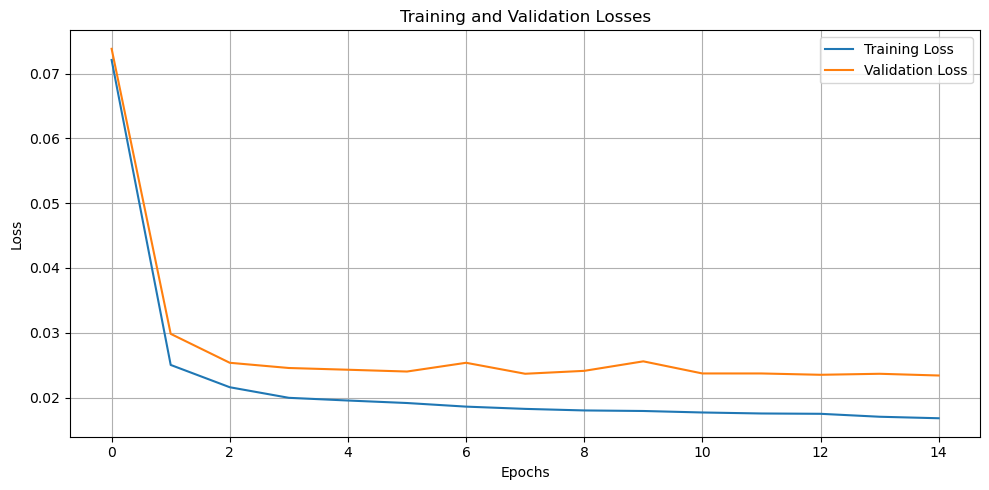

[I 2024-04-28 01:40:38,062] Trial 12 finished with value: 0.023402162686441883 and parameters: {'features': '64,128,256,512', 'dropout_rate': 0.40878798313963166, 'learning_rate': 0.00020982595307825853, 'weight_decay': 3.110575081913966e-06, 'timestep_interval': 4, 'batch_size': 16}. Best is trial 9 with value: 0.02170587465227347.


Epoch [1/15], Loss: 0.0935
Validation Loss: 0.0861
Current Learning Rate: [0.0009696777012106742]
Epoch [2/15], Loss: 0.0268
Validation Loss: 0.0286
Current Learning Rate: [0.0009696777012106742]
Epoch [3/15], Loss: 0.0215
Validation Loss: 0.0254
Current Learning Rate: [0.0009696777012106742]
Epoch [4/15], Loss: 0.0202
Validation Loss: 0.0250
Current Learning Rate: [0.0009696777012106742]
Epoch [5/15], Loss: 0.0199
Validation Loss: 0.0247
Current Learning Rate: [0.0009696777012106742]
Model saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/attempt3_trial_13/model_epoch_5.pth
Epoch [6/15], Loss: 0.0195
Validation Loss: 0.0249
Current Learning Rate: [0.0009696777012106742]
Epoch [7/15], Loss: 0.0191
Validation Loss: 0.0265
Current Learning Rate: [0.0009696777012106742]
Epoch [8/15], Loss: 0.0193
Validation Loss: 0.0242
Current Learning Rate: [0.0009696777012106742]
Epoch [9/15], Loss: 0.0190
Validation Loss: 0.0264
Current Learning Rate: [0.0009696777012106742]
Epoch [10/15],

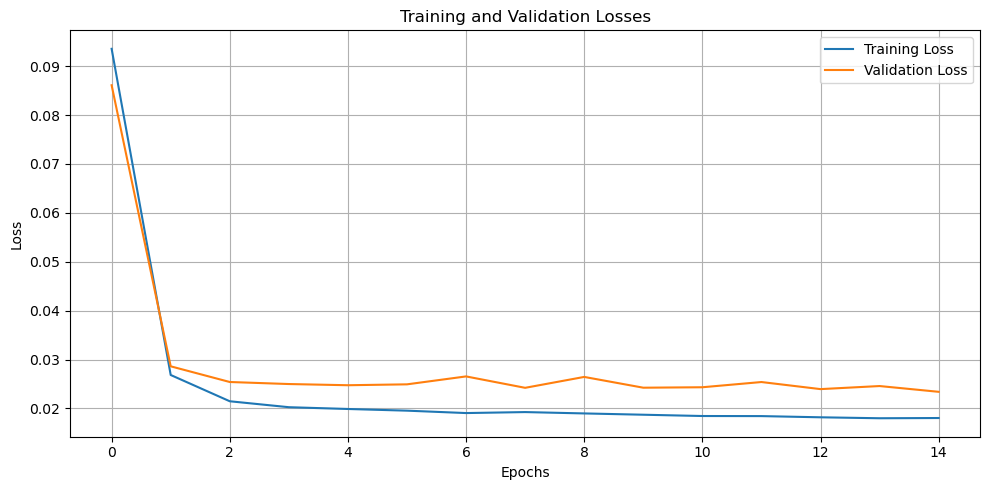

[I 2024-04-28 02:06:48,509] Trial 13 finished with value: 0.023396698674604074 and parameters: {'features': '64,128,256,512', 'dropout_rate': 0.3837213839456299, 'learning_rate': 0.0009696777012106742, 'weight_decay': 2.4195207071678838e-06, 'timestep_interval': 3, 'batch_size': 8}. Best is trial 9 with value: 0.02170587465227347.


Epoch [1/15], Loss: 0.1146
Validation Loss: 0.1056
Current Learning Rate: [0.0008172854655579154]
Epoch [2/15], Loss: 0.0338
Validation Loss: 0.0251
Current Learning Rate: [0.0008172854655579154]
Epoch [3/15], Loss: 0.0187
Validation Loss: 0.0236
Current Learning Rate: [0.0008172854655579154]
Epoch [4/15], Loss: 0.0177
Validation Loss: 0.0223
Current Learning Rate: [0.0008172854655579154]
Epoch [5/15], Loss: 0.0172
Validation Loss: 0.0223
Current Learning Rate: [0.0008172854655579154]
Model saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/attempt3_trial_14/model_epoch_5.pth
Epoch [6/15], Loss: 0.0171
Validation Loss: 0.0221
Current Learning Rate: [0.0008172854655579154]
Epoch [7/15], Loss: 0.0167
Validation Loss: 0.0219
Current Learning Rate: [0.0008172854655579154]
Epoch [8/15], Loss: 0.0163
Validation Loss: 0.0221
Current Learning Rate: [0.0008172854655579154]
Epoch [9/15], Loss: 0.0164
Validation Loss: 0.0214
Current Learning Rate: [0.0008172854655579154]
Epoch [10/15],

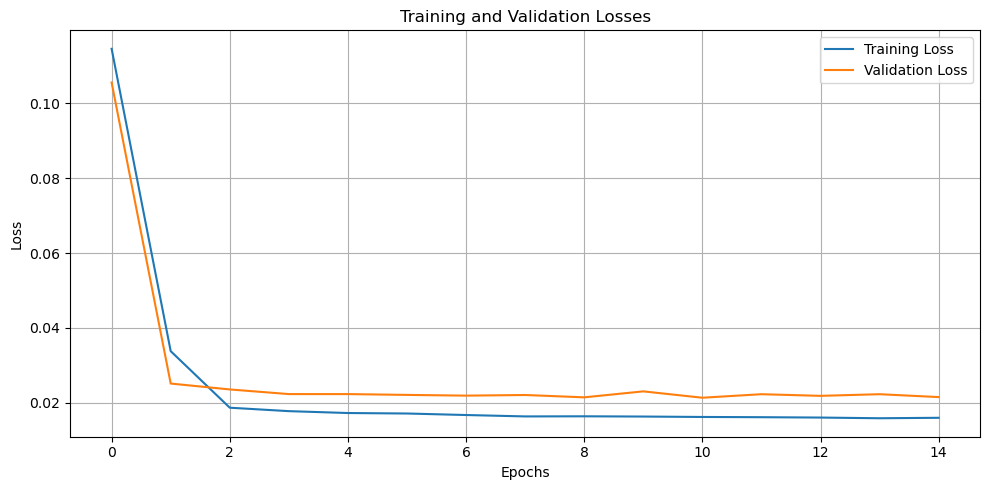

[I 2024-04-28 02:33:53,124] Trial 14 finished with value: 0.02133613543451897 and parameters: {'features': '64,128,256,512', 'dropout_rate': 0.363966266858029, 'learning_rate': 0.0008172854655579154, 'weight_decay': 1.9406248992548683e-05, 'timestep_interval': 1, 'batch_size': 8}. Best is trial 14 with value: 0.02133613543451897.


Epoch [1/15], Loss: 0.0881
Validation Loss: 0.0373
Current Learning Rate: [0.0005324332502960455]
Epoch [2/15], Loss: 0.0212
Validation Loss: 0.0241
Current Learning Rate: [0.0005324332502960455]
Epoch [3/15], Loss: 0.0183
Validation Loss: 0.0235
Current Learning Rate: [0.0005324332502960455]
Epoch [4/15], Loss: 0.0176
Validation Loss: 0.0229
Current Learning Rate: [0.0005324332502960455]
Epoch [5/15], Loss: 0.0172
Validation Loss: 0.0230
Current Learning Rate: [0.0005324332502960455]
Model saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/attempt3_trial_15/model_epoch_5.pth
Epoch [6/15], Loss: 0.0167
Validation Loss: 0.0229
Current Learning Rate: [0.0005324332502960455]
Epoch [7/15], Loss: 0.0167
Validation Loss: 0.0227
Current Learning Rate: [0.0005324332502960455]
Epoch [8/15], Loss: 0.0168
Validation Loss: 0.0232
Current Learning Rate: [0.0005324332502960455]
Epoch [9/15], Loss: 0.0166
Validation Loss: 0.0217
Current Learning Rate: [0.0005324332502960455]
Epoch [10/15],

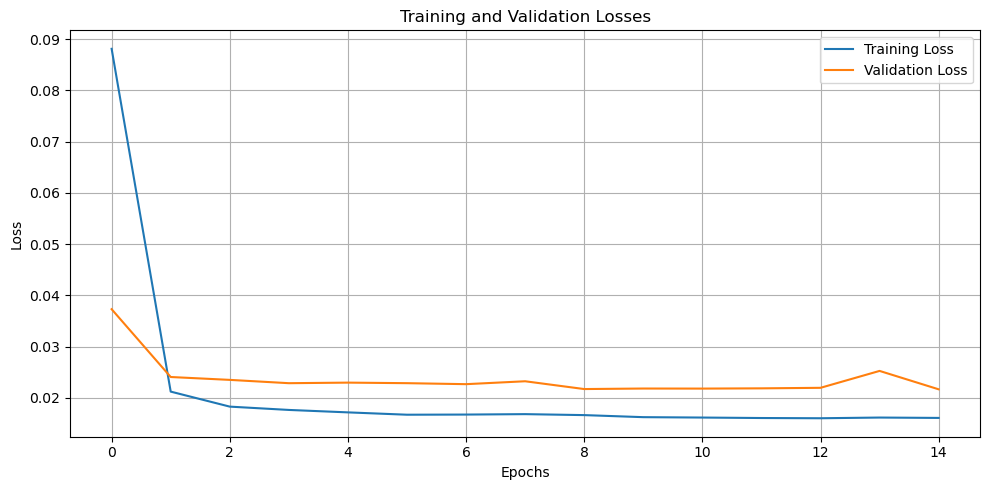

[I 2024-04-28 03:01:04,619] Trial 15 finished with value: 0.021669899293088487 and parameters: {'features': '64,128,256,512', 'dropout_rate': 0.3485104952450998, 'learning_rate': 0.0005324332502960455, 'weight_decay': 1.892185664242074e-05, 'timestep_interval': 1, 'batch_size': 8}. Best is trial 14 with value: 0.02133613543451897.


Epoch [1/15], Loss: 0.0842
Validation Loss: 0.1052
Current Learning Rate: [0.0003698167583891306]
Epoch [2/15], Loss: 0.0828
Validation Loss: 0.1052
Current Learning Rate: [0.0003698167583891306]
Epoch [3/15], Loss: 0.0579
Validation Loss: 0.0258
Current Learning Rate: [0.0003698167583891306]
Epoch [4/15], Loss: 0.0185
Validation Loss: 0.0246
Current Learning Rate: [0.0003698167583891306]
Epoch [5/15], Loss: 0.0175
Validation Loss: 0.0226
Current Learning Rate: [0.0003698167583891306]
Model saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/attempt3_trial_16/model_epoch_5.pth
Epoch [6/15], Loss: 0.0174
Validation Loss: 0.0221
Current Learning Rate: [0.0003698167583891306]
Epoch [7/15], Loss: 0.0169
Validation Loss: 0.0220
Current Learning Rate: [0.0003698167583891306]
Epoch [8/15], Loss: 0.0167
Validation Loss: 0.0223
Current Learning Rate: [0.0003698167583891306]
Epoch [9/15], Loss: 0.0165
Validation Loss: 0.0218
Current Learning Rate: [0.0003698167583891306]
Epoch [10/15],

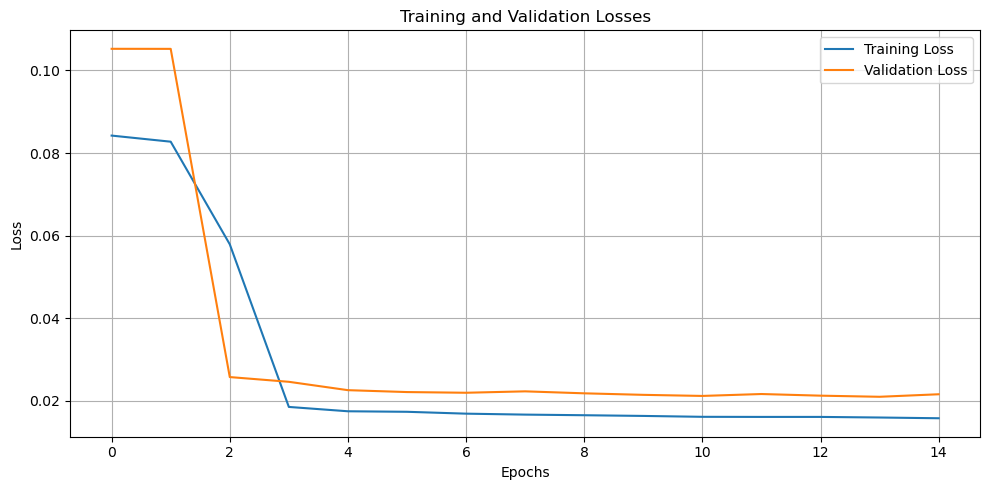

[I 2024-04-28 03:28:07,428] Trial 16 finished with value: 0.020996633754111826 and parameters: {'features': '64,128,256,512', 'dropout_rate': 0.2406018476500516, 'learning_rate': 0.0003698167583891306, 'weight_decay': 2.0376597275512204e-05, 'timestep_interval': 1, 'batch_size': 8}. Best is trial 16 with value: 0.020996633754111826.


Epoch [1/15], Loss: 0.1315
Validation Loss: 0.0975
Current Learning Rate: [0.00035085276240065576]
Epoch [2/15], Loss: 0.0420
Validation Loss: 0.0303
Current Learning Rate: [0.00035085276240065576]
Epoch [3/15], Loss: 0.0240
Validation Loss: 0.0300
Current Learning Rate: [0.00035085276240065576]
Epoch [4/15], Loss: 0.0228
Validation Loss: 0.0291
Current Learning Rate: [0.00035085276240065576]
Epoch [5/15], Loss: 0.0217
Validation Loss: 0.0276
Current Learning Rate: [0.00035085276240065576]
Model saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/attempt3_trial_17/model_epoch_5.pth
Epoch [6/15], Loss: 0.0203
Validation Loss: 0.0263
Current Learning Rate: [0.00035085276240065576]
Epoch [7/15], Loss: 0.0197
Validation Loss: 0.0254
Current Learning Rate: [0.00035085276240065576]
Epoch [8/15], Loss: 0.0193
Validation Loss: 0.0252
Current Learning Rate: [0.00035085276240065576]
Epoch [9/15], Loss: 0.0186
Validation Loss: 0.0245
Current Learning Rate: [0.00035085276240065576]
Epoch

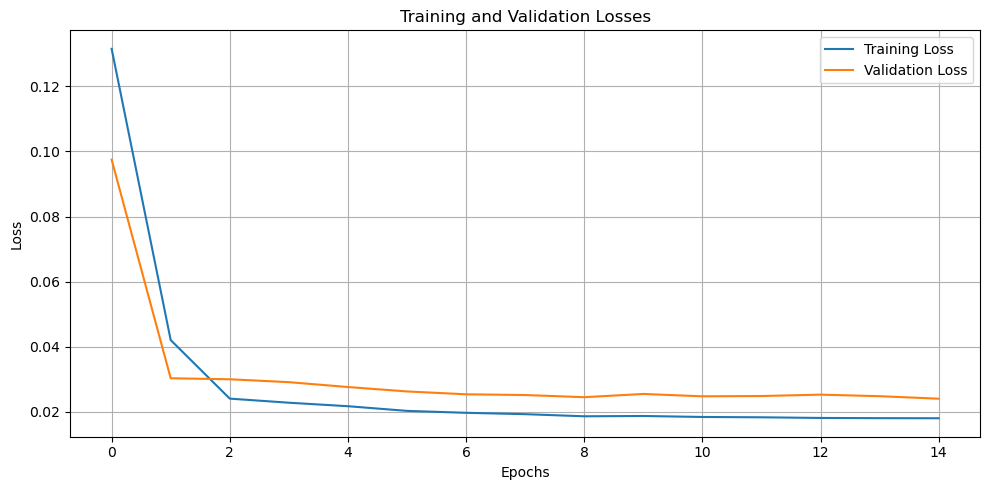

[I 2024-04-28 03:54:23,173] Trial 17 finished with value: 0.02402400154509206 and parameters: {'features': '64,128,256,512', 'dropout_rate': 0.23418085602732652, 'learning_rate': 0.00035085276240065576, 'weight_decay': 2.425326123924387e-05, 'timestep_interval': 3, 'batch_size': 8}. Best is trial 16 with value: 0.020996633754111826.


Epoch [1/15], Loss: 0.0912
Validation Loss: 0.1040
Current Learning Rate: [0.00015860303239568016]
Epoch [2/15], Loss: 0.0570
Validation Loss: 0.0319
Current Learning Rate: [0.00015860303239568016]
Epoch [3/15], Loss: 0.0236
Validation Loss: 0.0297
Current Learning Rate: [0.00015860303239568016]
Epoch [4/15], Loss: 0.0225
Validation Loss: 0.0288
Current Learning Rate: [0.00015860303239568016]
Epoch [5/15], Loss: 0.0217
Validation Loss: 0.0285
Current Learning Rate: [0.00015860303239568016]
Model saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/attempt3_trial_18/model_epoch_5.pth
Epoch [6/15], Loss: 0.0212
Validation Loss: 0.0284
Current Learning Rate: [0.00015860303239568016]
Epoch [7/15], Loss: 0.0208
Validation Loss: 0.0301
Current Learning Rate: [0.00015860303239568016]
Epoch [8/15], Loss: 0.0204
Validation Loss: 0.0277
Current Learning Rate: [0.00015860303239568016]
Epoch [9/15], Loss: 0.0202
Validation Loss: 0.0282
Current Learning Rate: [0.00015860303239568016]
Epoch

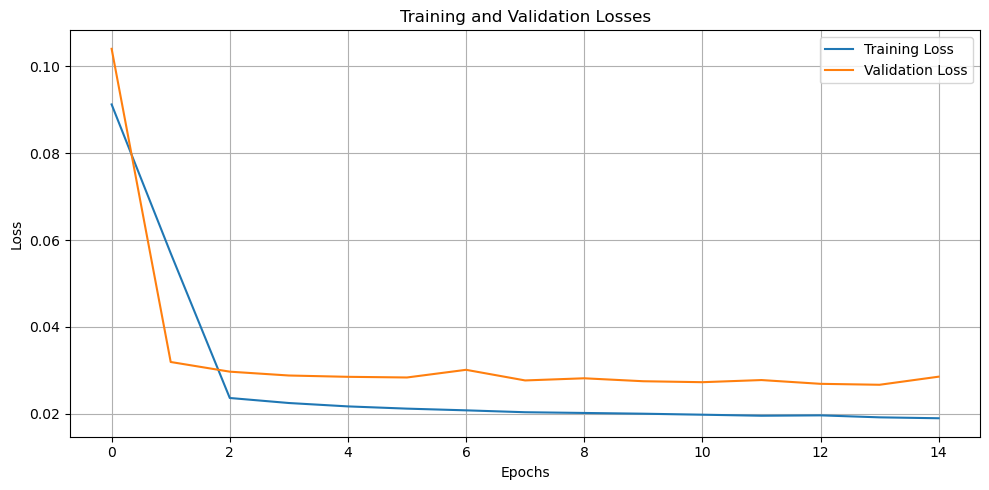

[I 2024-04-28 04:16:12,492] Trial 18 finished with value: 0.026673461465785902 and parameters: {'features': '64,128,256', 'dropout_rate': 0.16242097676135403, 'learning_rate': 0.00015860303239568016, 'weight_decay': 3.8818451036058234e-05, 'timestep_interval': 2, 'batch_size': 8}. Best is trial 16 with value: 0.020996633754111826.


Epoch [1/15], Loss: 0.0817
Validation Loss: 0.0803
Current Learning Rate: [0.0009347040619843796]
Epoch [2/15], Loss: 0.0452
Validation Loss: 0.0329
Current Learning Rate: [0.0009347040619843796]
Epoch [3/15], Loss: 0.0274
Validation Loss: 0.0298
Current Learning Rate: [0.0009347040619843796]
Epoch [4/15], Loss: 0.0256
Validation Loss: 0.0319
Current Learning Rate: [0.0009347040619843796]
Epoch [5/15], Loss: 0.0251
Validation Loss: 0.0297
Current Learning Rate: [0.0009347040619843796]
Model saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/attempt3_trial_19/model_epoch_5.pth
Epoch [6/15], Loss: 0.0243
Validation Loss: 0.0310
Current Learning Rate: [0.0009347040619843796]
Epoch [7/15], Loss: 0.0238
Validation Loss: 0.0291
Current Learning Rate: [0.0009347040619843796]
Epoch [8/15], Loss: 0.0237
Validation Loss: 0.0284
Current Learning Rate: [0.0009347040619843796]
Epoch [9/15], Loss: 0.0237
Validation Loss: 0.0283
Current Learning Rate: [0.0009347040619843796]
Epoch [10/15],

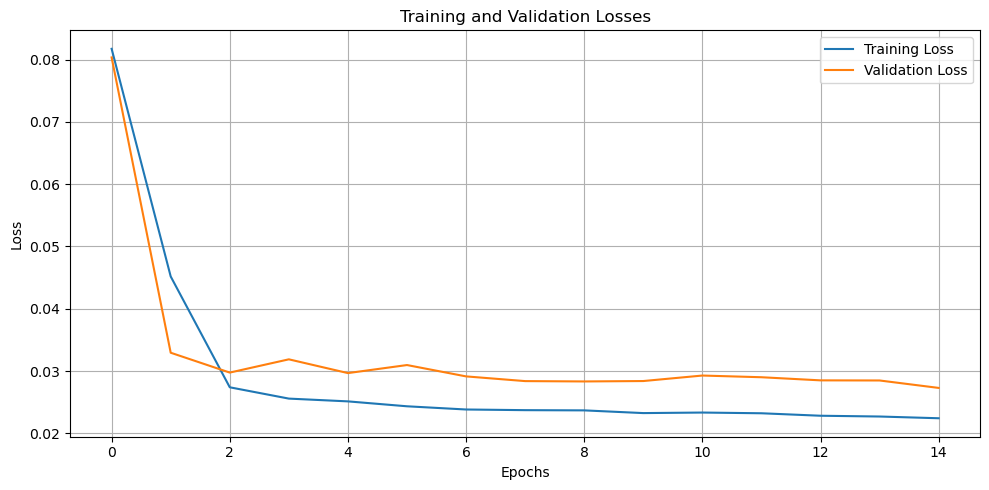

[I 2024-04-28 04:41:05,288] Trial 19 finished with value: 0.02728809562644788 and parameters: {'features': '64,128,256,512', 'dropout_rate': 0.2673104743197812, 'learning_rate': 0.0009347040619843796, 'weight_decay': 1.6016781612699118e-05, 'timestep_interval': 6, 'batch_size': 8}. Best is trial 16 with value: 0.020996633754111826.


Epoch [1/15], Loss: 0.0590
Validation Loss: 0.0335
Current Learning Rate: [0.00033436128955451885]
Epoch [2/15], Loss: 0.0226
Validation Loss: 0.0259
Current Learning Rate: [0.00033436128955451885]
Epoch [3/15], Loss: 0.0206
Validation Loss: 0.0256
Current Learning Rate: [0.00033436128955451885]
Epoch [4/15], Loss: 0.0198
Validation Loss: 0.0258
Current Learning Rate: [0.00033436128955451885]
Epoch [5/15], Loss: 0.0194
Validation Loss: 0.0251
Current Learning Rate: [0.00033436128955451885]
Model saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/attempt3_trial_20/model_epoch_5.pth
Epoch [6/15], Loss: 0.0190
Validation Loss: 0.0243
Current Learning Rate: [0.00033436128955451885]
Epoch [7/15], Loss: 0.0185
Validation Loss: 0.0246
Current Learning Rate: [0.00033436128955451885]
Epoch [8/15], Loss: 0.0185
Validation Loss: 0.0241
Current Learning Rate: [0.00033436128955451885]
Epoch [9/15], Loss: 0.0184
Validation Loss: 0.0245
Current Learning Rate: [0.00033436128955451885]
Epoch

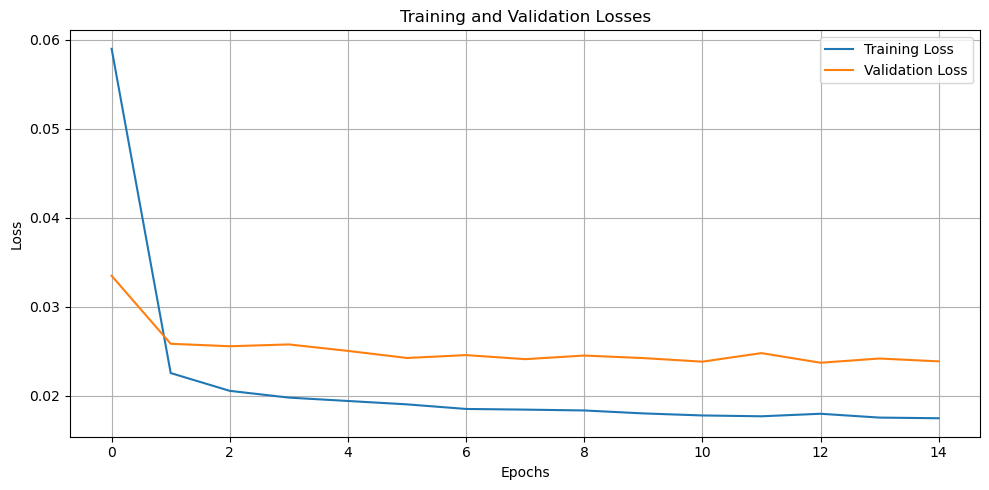

[I 2024-04-28 05:07:13,679] Trial 20 finished with value: 0.023721067568481857 and parameters: {'features': '64,128,256,512', 'dropout_rate': 0.1833104956431222, 'learning_rate': 0.00033436128955451885, 'weight_decay': 1.293702546681764e-05, 'timestep_interval': 3, 'batch_size': 8}. Best is trial 16 with value: 0.020996633754111826.


Epoch [1/15], Loss: 0.1263
Validation Loss: 0.1060
Current Learning Rate: [0.0004966872542183035]
Epoch [2/15], Loss: 0.0829
Validation Loss: 0.1052
Current Learning Rate: [0.0004966872542183035]
Epoch [3/15], Loss: 0.0616
Validation Loss: 0.0271
Current Learning Rate: [0.0004966872542183035]
Epoch [4/15], Loss: 0.0198
Validation Loss: 0.0256
Current Learning Rate: [0.0004966872542183035]
Epoch [5/15], Loss: 0.0181
Validation Loss: 0.0244
Current Learning Rate: [0.0004966872542183035]
Model saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/attempt3_trial_21/model_epoch_5.pth
Epoch [6/15], Loss: 0.0177
Validation Loss: 0.0239
Current Learning Rate: [0.0004966872542183035]
Epoch [7/15], Loss: 0.0172
Validation Loss: 0.0241
Current Learning Rate: [0.0004966872542183035]
Epoch [8/15], Loss: 0.0169
Validation Loss: 0.0224
Current Learning Rate: [0.0004966872542183035]
Epoch [9/15], Loss: 0.0166
Validation Loss: 0.0222
Current Learning Rate: [0.0004966872542183035]
Epoch [10/15],

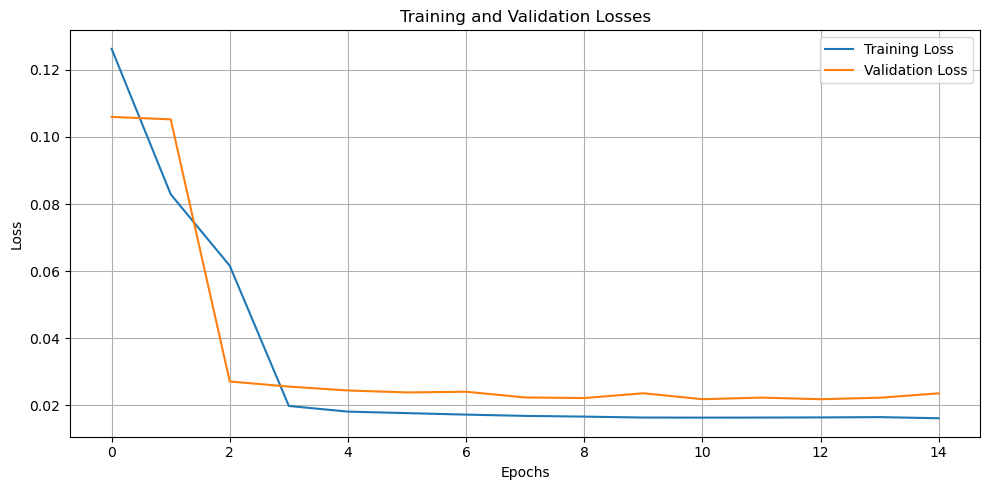

[I 2024-04-28 05:34:34,684] Trial 21 finished with value: 0.021838926231222494 and parameters: {'features': '64,128,256,512', 'dropout_rate': 0.3356188631971994, 'learning_rate': 0.0004966872542183035, 'weight_decay': 3.231536190186754e-05, 'timestep_interval': 1, 'batch_size': 8}. Best is trial 16 with value: 0.020996633754111826.


Epoch [1/15], Loss: 0.0908
Validation Loss: 0.1054
Current Learning Rate: [0.0005625920474373499]
Epoch [2/15], Loss: 0.0825
Validation Loss: 0.1052
Current Learning Rate: [0.0005625920474373499]
Epoch [3/15], Loss: 0.0828
Validation Loss: 0.1052
Current Learning Rate: [0.0005625920474373499]
Epoch [4/15], Loss: 0.0831
Validation Loss: 0.1052
Current Learning Rate: [0.0005625920474373499]
Epoch [5/15], Loss: 0.0825
Validation Loss: 0.1052
Current Learning Rate: [0.0005625920474373499]
Model saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/attempt3_trial_22/model_epoch_5.pth
Epoch [6/15], Loss: 0.0830
Validation Loss: 0.1052
Current Learning Rate: [0.0005625920474373499]
Epoch [7/15], Loss: 0.0827
Validation Loss: 0.1052
Current Learning Rate: [0.0005625920474373499]
Epoch [8/15], Loss: 0.0825
Validation Loss: 0.1052
Current Learning Rate: [5.6259204743735e-05]
Epoch [9/15], Loss: 0.0827
Validation Loss: 0.1052
Current Learning Rate: [5.6259204743735e-05]
Epoch [10/15], Los

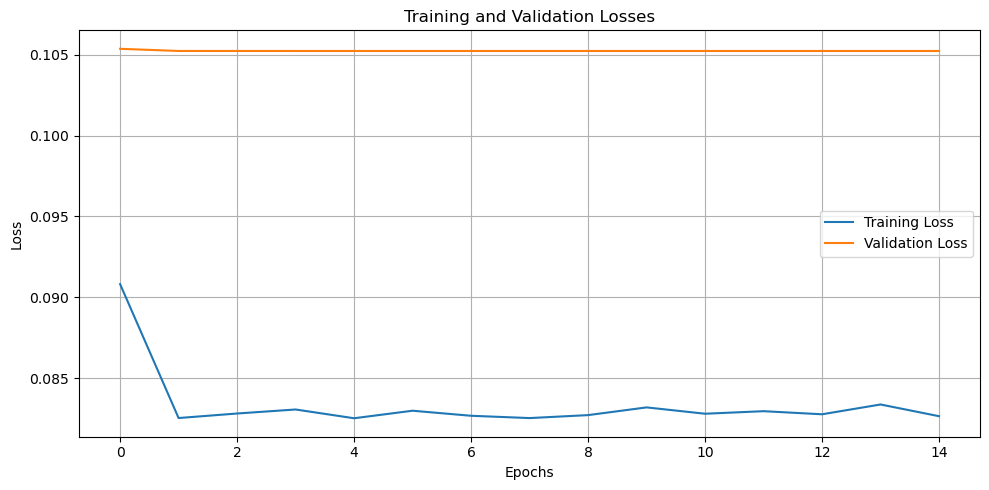

[I 2024-04-28 06:01:38,727] Trial 22 finished with value: 0.10522832521902663 and parameters: {'features': '64,128,256,512', 'dropout_rate': 0.3623505643674636, 'learning_rate': 0.0005625920474373499, 'weight_decay': 1.7152629556657407e-05, 'timestep_interval': 1, 'batch_size': 8}. Best is trial 16 with value: 0.020996633754111826.


Epoch [1/15], Loss: 0.0887
Validation Loss: 0.1052
Current Learning Rate: [0.00011307579910903694]
Epoch [2/15], Loss: 0.0424
Validation Loss: 0.0314
Current Learning Rate: [0.00011307579910903694]
Epoch [3/15], Loss: 0.0227
Validation Loss: 0.0292
Current Learning Rate: [0.00011307579910903694]
Epoch [4/15], Loss: 0.0209
Validation Loss: 0.0282
Current Learning Rate: [0.00011307579910903694]
Epoch [5/15], Loss: 0.0196
Validation Loss: 0.0264
Current Learning Rate: [0.00011307579910903694]
Model saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/attempt3_trial_23/model_epoch_5.pth
Epoch [6/15], Loss: 0.0191
Validation Loss: 0.0270
Current Learning Rate: [0.00011307579910903694]
Epoch [7/15], Loss: 0.0186
Validation Loss: 0.0258
Current Learning Rate: [0.00011307579910903694]
Epoch [8/15], Loss: 0.0182
Validation Loss: 0.0275
Current Learning Rate: [0.00011307579910903694]
Epoch [9/15], Loss: 0.0182
Validation Loss: 0.0248
Current Learning Rate: [0.00011307579910903694]
Epoch

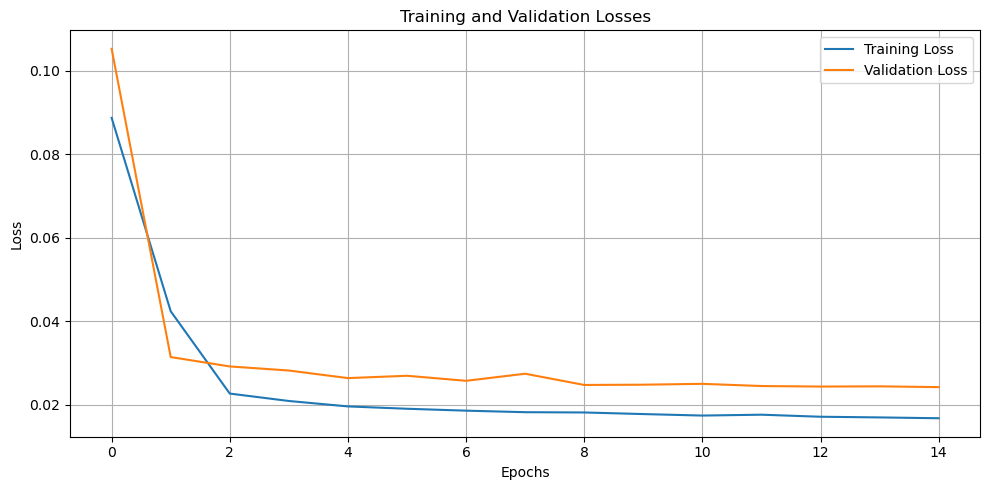

[I 2024-04-28 06:28:26,438] Trial 23 finished with value: 0.02424622101344816 and parameters: {'features': '64,128,256,512', 'dropout_rate': 0.2920995263633555, 'learning_rate': 0.00011307579910903694, 'weight_decay': 4.541191331897803e-05, 'timestep_interval': 2, 'batch_size': 8}. Best is trial 16 with value: 0.020996633754111826.


Epoch [1/15], Loss: 0.0994
Validation Loss: 0.1062
Current Learning Rate: [0.0002456219941376875]
Epoch [2/15], Loss: 0.0824
Validation Loss: 0.1052
Current Learning Rate: [0.0002456219941376875]
Epoch [3/15], Loss: 0.0828
Validation Loss: 0.1052
Current Learning Rate: [0.0002456219941376875]
Epoch [4/15], Loss: 0.0824
Validation Loss: 0.1052
Current Learning Rate: [0.0002456219941376875]
Epoch [5/15], Loss: 0.0825
Validation Loss: 0.1052
Current Learning Rate: [0.0002456219941376875]
Model saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/attempt3_trial_24/model_epoch_5.pth
Epoch [6/15], Loss: 0.0833
Validation Loss: 0.1052
Current Learning Rate: [0.0002456219941376875]
Epoch [7/15], Loss: 0.0829
Validation Loss: 0.1052
Current Learning Rate: [0.0002456219941376875]
Epoch [8/15], Loss: 0.0828
Validation Loss: 0.1052
Current Learning Rate: [0.0002456219941376875]
Epoch [9/15], Loss: 0.0828
Validation Loss: 0.1052
Current Learning Rate: [0.0002456219941376875]
Epoch [10/15],

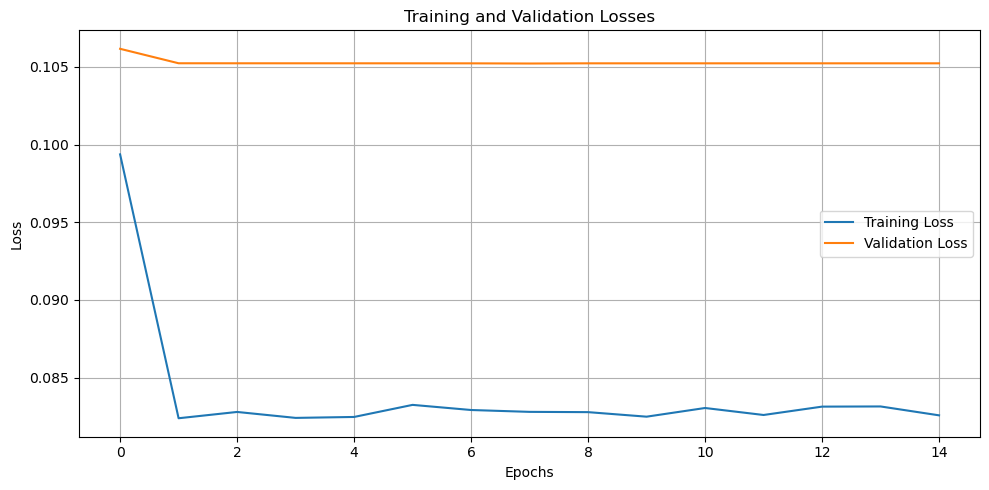

[I 2024-04-28 06:55:23,547] Trial 24 finished with value: 0.10521581858130438 and parameters: {'features': '64,128,256,512', 'dropout_rate': 0.2745279641249553, 'learning_rate': 0.0002456219941376875, 'weight_decay': 9.64486158710998e-05, 'timestep_interval': 1, 'batch_size': 8}. Best is trial 16 with value: 0.020996633754111826.


Epoch [1/15], Loss: 0.0457
Validation Loss: 0.0388
Current Learning Rate: [0.000828381039380201]
Epoch [2/15], Loss: 0.0221
Validation Loss: 0.0271
Current Learning Rate: [0.000828381039380201]
Epoch [3/15], Loss: 0.0207
Validation Loss: 0.0266
Current Learning Rate: [0.000828381039380201]
Epoch [4/15], Loss: 0.0201
Validation Loss: 0.0262
Current Learning Rate: [0.000828381039380201]
Epoch [5/15], Loss: 0.0199
Validation Loss: 0.0253
Current Learning Rate: [0.000828381039380201]
Model saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/attempt3_trial_25/model_epoch_5.pth
Epoch [6/15], Loss: 0.0195
Validation Loss: 0.0246
Current Learning Rate: [0.000828381039380201]
Epoch [7/15], Loss: 0.0192
Validation Loss: 0.0251
Current Learning Rate: [0.000828381039380201]
Epoch [8/15], Loss: 0.0191
Validation Loss: 0.0253
Current Learning Rate: [0.000828381039380201]
Epoch [9/15], Loss: 0.0188
Validation Loss: 0.0255
Current Learning Rate: [0.000828381039380201]
Epoch [10/15], Loss: 0.

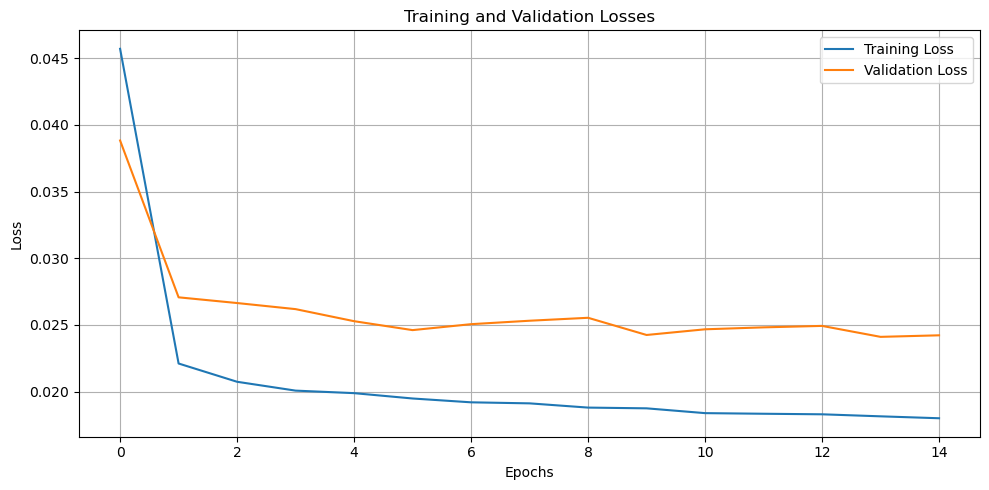

[I 2024-04-28 07:21:40,151] Trial 25 finished with value: 0.02411163863795462 and parameters: {'features': '64,128,256,512', 'dropout_rate': 0.3500986848187774, 'learning_rate': 0.000828381039380201, 'weight_decay': 1.0223700462340908e-05, 'timestep_interval': 3, 'batch_size': 8}. Best is trial 16 with value: 0.020996633754111826.


Epoch [1/15], Loss: 0.0909
Validation Loss: 0.0997
Current Learning Rate: [0.0004276970058607671]
Epoch [2/15], Loss: 0.0489
Validation Loss: 0.0282
Current Learning Rate: [0.0004276970058607671]
Epoch [3/15], Loss: 0.0207
Validation Loss: 0.0273
Current Learning Rate: [0.0004276970058607671]
Epoch [4/15], Loss: 0.0197
Validation Loss: 0.0254
Current Learning Rate: [0.0004276970058607671]
Epoch [5/15], Loss: 0.0191
Validation Loss: 0.0250
Current Learning Rate: [0.0004276970058607671]
Model saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/attempt3_trial_26/model_epoch_5.pth
Epoch [6/15], Loss: 0.0189
Validation Loss: 0.0258
Current Learning Rate: [0.0004276970058607671]
Epoch [7/15], Loss: 0.0187
Validation Loss: 0.0247
Current Learning Rate: [0.0004276970058607671]
Epoch [8/15], Loss: 0.0183
Validation Loss: 0.0244
Current Learning Rate: [0.0004276970058607671]
Epoch [9/15], Loss: 0.0183
Validation Loss: 0.0243
Current Learning Rate: [0.0004276970058607671]
Epoch [10/15],

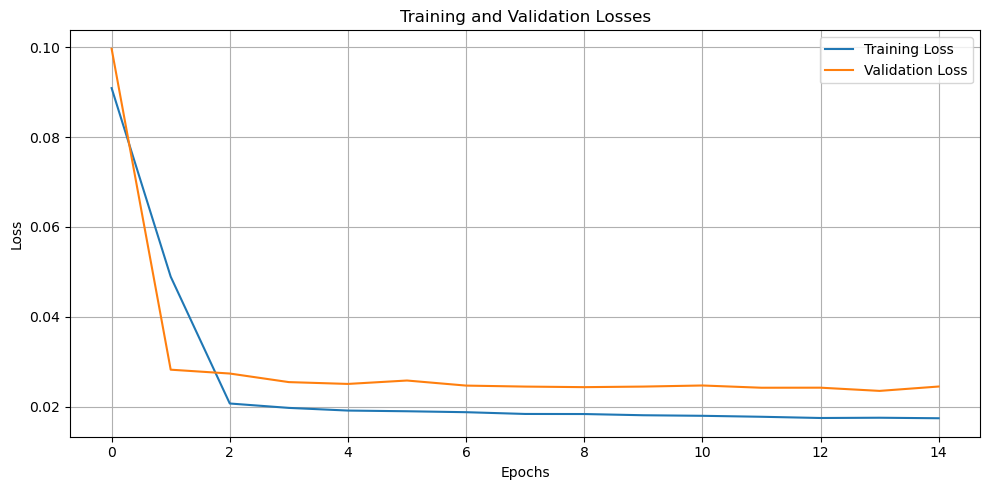

[I 2024-04-28 07:50:30,670] Trial 26 finished with value: 0.023478089501082464 and parameters: {'features': '64,128,256,512', 'dropout_rate': 0.2075684206137403, 'learning_rate': 0.0004276970058607671, 'weight_decay': 2.072293786168224e-05, 'timestep_interval': 2, 'batch_size': 8}. Best is trial 16 with value: 0.020996633754111826.


Epoch [1/15], Loss: 0.0740
Validation Loss: 0.0339
Current Learning Rate: [0.0006749949923651026]
Epoch [2/15], Loss: 0.0230
Validation Loss: 0.0278
Current Learning Rate: [0.0006749949923651026]
Epoch [3/15], Loss: 0.0208
Validation Loss: 0.0264
Current Learning Rate: [0.0006749949923651026]
Epoch [4/15], Loss: 0.0197
Validation Loss: 0.0252
Current Learning Rate: [0.0006749949923651026]
Epoch [5/15], Loss: 0.0197
Validation Loss: 0.0251
Current Learning Rate: [0.0006749949923651026]
Model saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/attempt3_trial_27/model_epoch_5.pth
Epoch [6/15], Loss: 0.0195
Validation Loss: 0.0255
Current Learning Rate: [0.0006749949923651026]
Epoch [7/15], Loss: 0.0191
Validation Loss: 0.0252
Current Learning Rate: [0.0006749949923651026]
Epoch [8/15], Loss: 0.0191
Validation Loss: 0.0240
Current Learning Rate: [0.0006749949923651026]
Epoch [9/15], Loss: 0.0186
Validation Loss: 0.0250
Current Learning Rate: [0.0006749949923651026]
Epoch [10/15],

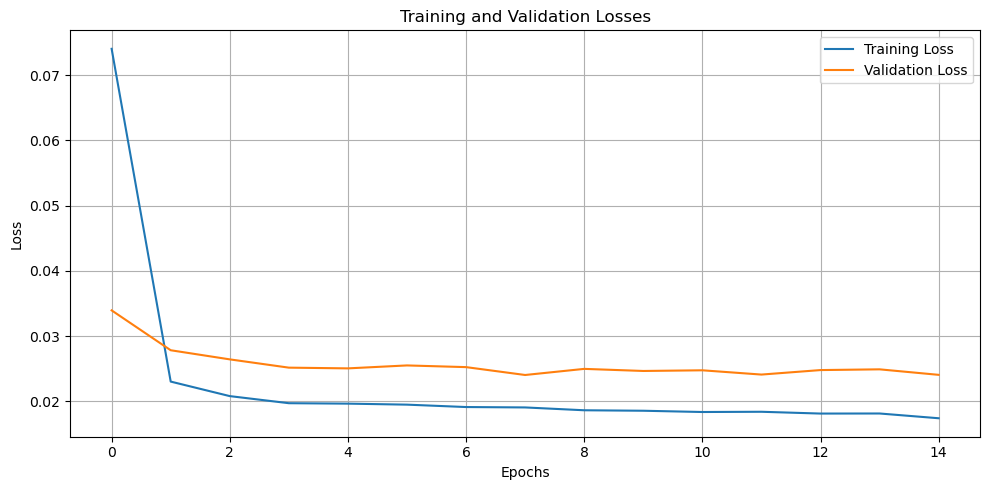

[I 2024-04-28 08:11:42,517] Trial 27 finished with value: 0.024041104028583504 and parameters: {'features': '64,128,256', 'dropout_rate': 0.4499068808150351, 'learning_rate': 0.0006749949923651026, 'weight_decay': 1.2568180355632336e-05, 'timestep_interval': 5, 'batch_size': 8}. Best is trial 16 with value: 0.020996633754111826.


Epoch [1/15], Loss: 0.0630
Validation Loss: 0.0522
Current Learning Rate: [0.00040230039190498586]
Epoch [2/15], Loss: 0.0289
Validation Loss: 0.0288
Current Learning Rate: [0.00040230039190498586]
Epoch [3/15], Loss: 0.0240
Validation Loss: 0.0281
Current Learning Rate: [0.00040230039190498586]
Epoch [4/15], Loss: 0.0233
Validation Loss: 0.0279
Current Learning Rate: [0.00040230039190498586]
Epoch [5/15], Loss: 0.0222
Validation Loss: 0.0297
Current Learning Rate: [0.00040230039190498586]
Model saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/attempt3_trial_28/model_epoch_5.pth
Epoch [6/15], Loss: 0.0219
Validation Loss: 0.0282
Current Learning Rate: [0.00040230039190498586]
Epoch [7/15], Loss: 0.0215
Validation Loss: 0.0264
Current Learning Rate: [0.00040230039190498586]
Epoch [8/15], Loss: 0.0212
Validation Loss: 0.0269
Current Learning Rate: [0.00040230039190498586]
Epoch [9/15], Loss: 0.0214
Validation Loss: 0.0278
Current Learning Rate: [0.00040230039190498586]
Epoch

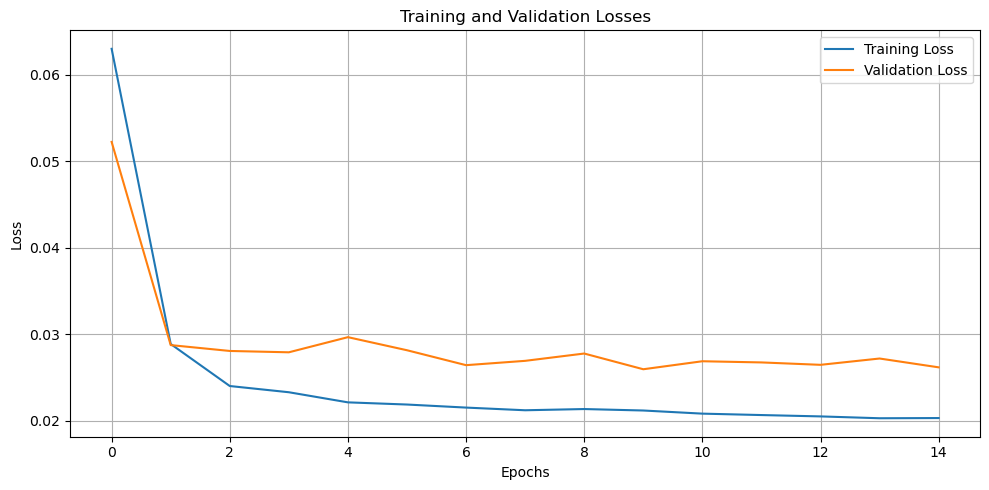

[I 2024-04-28 08:35:05,857] Trial 28 finished with value: 0.02597565667960664 and parameters: {'features': '64,128,256,512', 'dropout_rate': 0.364377531640415, 'learning_rate': 0.00040230039190498586, 'weight_decay': 2.9507941772191994e-05, 'timestep_interval': 10, 'batch_size': 8}. Best is trial 16 with value: 0.020996633754111826.


Epoch [1/15], Loss: 0.0905
Validation Loss: 0.1038
Current Learning Rate: [0.00018329176036386646]
Epoch [2/15], Loss: 0.0702
Validation Loss: 0.0301
Current Learning Rate: [0.00018329176036386646]
Epoch [3/15], Loss: 0.0218
Validation Loss: 0.0269
Current Learning Rate: [0.00018329176036386646]
Epoch [4/15], Loss: 0.0205
Validation Loss: 0.0252
Current Learning Rate: [0.00018329176036386646]
Epoch [5/15], Loss: 0.0195
Validation Loss: 0.0241
Current Learning Rate: [0.00018329176036386646]
Model saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/attempt3_trial_29/model_epoch_5.pth
Epoch [6/15], Loss: 0.0183
Validation Loss: 0.0222
Current Learning Rate: [0.00018329176036386646]
Epoch [7/15], Loss: 0.0171
Validation Loss: 0.0230
Current Learning Rate: [0.00018329176036386646]
Epoch [8/15], Loss: 0.0167
Validation Loss: 0.0225
Current Learning Rate: [0.00018329176036386646]
Epoch [9/15], Loss: 0.0165
Validation Loss: 0.0215
Current Learning Rate: [0.00018329176036386646]
Epoch

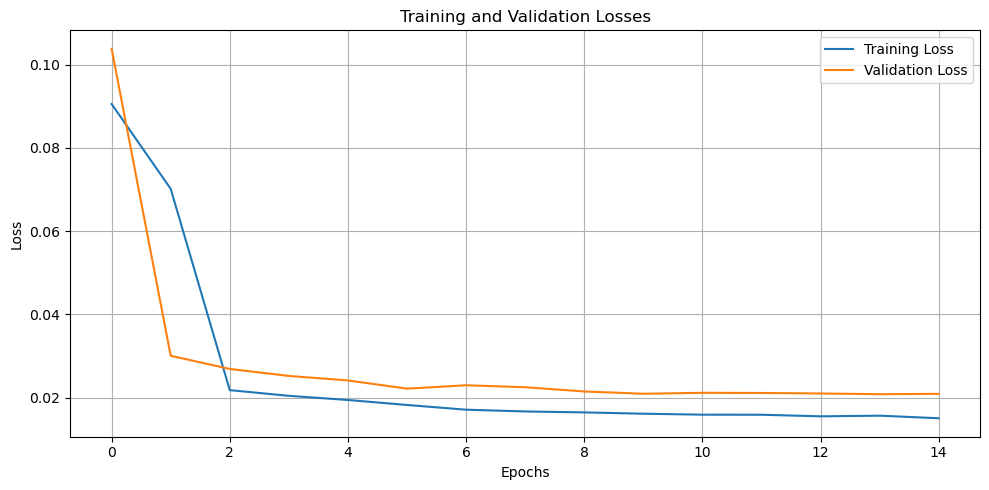

[I 2024-04-28 09:01:29,782] Trial 29 finished with value: 0.02084372440086944 and parameters: {'features': '64,128,256,512', 'dropout_rate': 0.4392982882008797, 'learning_rate': 0.00018329176036386646, 'weight_decay': 7.560066479603208e-06, 'timestep_interval': 1, 'batch_size': 16}. Best is trial 29 with value: 0.02084372440086944.


Best hyperparameters: {'features': '64,128,256,512', 'dropout_rate': 0.4392982882008797, 'learning_rate': 0.00018329176036386646, 'weight_decay': 7.560066479603208e-06, 'timestep_interval': 1, 'batch_size': 16}
Best value: 0.02084372440086944


In [5]:
# Create an Optuna study
study = optuna.create_study(study_name="attempt3", direction='minimize')

# Optimize the objective function
study.optimize(objective, n_trials=30)

# Print the best hyperparameters and best value
print("Best hyperparameters:", study.best_params)
print("Best value:", study.best_value)

In [6]:
# Plot optimization history
vis.plot_optimization_history(study)


In [7]:

# Plot intermediate values
vis.plot_intermediate_values(study)


[W 2024-04-28 09:01:29,953] You need to set up the pruning feature to utilize `plot_intermediate_values()`


In [8]:

# Plot parallel coordinate
vis.plot_parallel_coordinate(study)


In [9]:

# Plot contour (example with 'learning_rate' and 'weight_decay' hyperparameters)
vis.plot_contour(study, params=['learning_rate', 'weight_decay'])


In [10]:

# Plot slice (example with 'dropout_rate' hyperparameter)
vis.plot_slice(study, params=['dropout_rate'])


In [11]:

# Plot parameter importances
vis.plot_param_importances(study)